In [147]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import torch
from transformers import AutoModel, BertTokenizerFast, AdamW
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [148]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [149]:
dataset_train = load_dataset("toxigen/toxigen-data", split = "train")
dataset_test = load_dataset("toxigen/toxigen-data", split = "test")

dataset_train, dataset_test

(Dataset({
     features: ['text', 'target_group', 'factual?', 'ingroup_effect', 'lewd', 'framing', 'predicted_group', 'stereotyping', 'intent', 'toxicity_ai', 'toxicity_human', 'predicted_author', 'actual_method'],
     num_rows: 8960
 }),
 Dataset({
     features: ['text', 'target_group', 'factual?', 'ingroup_effect', 'lewd', 'framing', 'predicted_group', 'stereotyping', 'intent', 'toxicity_ai', 'toxicity_human', 'predicted_author', 'actual_method'],
     num_rows: 940
 }))

In [150]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Pre-procesamos los textos para no tener que hacerlo durante el training. Los textos se tokenizan y se hace padding de ceros para que todos los batches tengan el mismo tamaño. Los labels se normalizan entre 0 y 1.

In [151]:
train_text = dataset_train[:8000]["text"]
train_labels = torch.tensor(dataset_train[:8000]["toxicity_human"]) / 5.0
train_tokens = tokenizer.batch_encode_plus(train_text, max_length = 30, pad_to_max_length = True, truncation = True)

val_text = dataset_train[8000:]["text"]
val_labels = torch.tensor(dataset_train[8000:]["toxicity_human"]) / 5.0
val_tokens = tokenizer.batch_encode_plus(val_text, max_length = 30, pad_to_max_length = True, truncation = True)

test_text = dataset_test["text"]
test_labels = torch.tensor(dataset_test["toxicity_human"]) / 5.0
test_tokens = tokenizer.batch_encode_plus(test_text, max_length = 30, pad_to_max_length = True, truncation = True)

/mnt/disk2/msinnona/miniconda3/envs/martin/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [152]:
print(train_tokens["input_ids"][0])

[101, 4004, 2015, 2024, 2667, 2000, 2202, 2058, 1996, 2088, 2007, 2037, 16894, 4813, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Nos interesa quedarnos con los ids de los tokens y las máscaras de atención que van a indicar que porción corresponde a tokens y cual corresponde a padding.

In [153]:
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])

val_seq = torch.tensor(val_tokens['input_ids'])
val_mask = torch.tensor(val_tokens['attention_mask'])

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])

In [154]:
batch_size = 1000

train_data = TensorDataset(train_seq, train_mask, train_labels)
train_dataloader = DataLoader(train_data, batch_size = batch_size)

val_data = TensorDataset(val_seq, val_mask, val_labels)
val_dataloader = DataLoader(val_data, batch_size = batch_size)

Vamos a freezar todos los parámetros de Bert. Solo nos interesa finetunear el final de la arquitectura

In [155]:
for param in bert.parameters():
    param.requires_grad = False

Definimos capas extras para la regresión. Se espera que la salida sea un número entre 0 y 1 que indica la toxicidad del texto

In [156]:
class BERT_toxic(nn.Module):

    def __init__(self, bert):
      
      super(BERT_toxic, self).__init__()

      self.bert = bert 
      
      self.dropout = nn.Dropout(0.2)
      self.relu =  nn.ReLU()

      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,1)

    def forward(self, sent_id, mask):

      _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      
      x = torch.sigmoid(x)
      return x

In [157]:
model = BERT_toxic(bert)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr = 1e-4)
criterion = nn.MSELoss()

/mnt/disk2/msinnona/miniconda3/envs/martin/lib/python3.12/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Podemos ver la diferencia en el número de parámetros del modelo freezado

In [158]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

394241

In [159]:
epochs = 1000
losses = []

model.train()

for epoch in range(epochs):

    total_loss = 0

    for step, batch in enumerate(train_dataloader):

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        model.zero_grad()        

        preds = model(sent_id, mask).squeeze(1)

        loss = criterion(preds, labels)
        total_loss = total_loss + loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    losses.append(avg_loss)

    if epoch % 10 == 0: print(f"epoch: {epoch} | {loss.item():.4f}")

epoch: 0 | 0.0829
epoch: 10 | 0.0696
epoch: 20 | 0.0643
epoch: 30 | 0.0591
epoch: 40 | 0.0574
epoch: 50 | 0.0558
epoch: 60 | 0.0533
epoch: 70 | 0.0530
epoch: 80 | 0.0531
epoch: 90 | 0.0540
epoch: 100 | 0.0545
epoch: 110 | 0.0528
epoch: 120 | 0.0534
epoch: 130 | 0.0520
epoch: 140 | 0.0525
epoch: 150 | 0.0509
epoch: 160 | 0.0503
epoch: 170 | 0.0519
epoch: 180 | 0.0505
epoch: 190 | 0.0517
epoch: 200 | 0.0516
epoch: 210 | 0.0505
epoch: 220 | 0.0497
epoch: 230 | 0.0483
epoch: 240 | 0.0487
epoch: 250 | 0.0500
epoch: 260 | 0.0494
epoch: 270 | 0.0493
epoch: 280 | 0.0487
epoch: 290 | 0.0477
epoch: 300 | 0.0497
epoch: 310 | 0.0486
epoch: 320 | 0.0482
epoch: 330 | 0.0489
epoch: 340 | 0.0475
epoch: 350 | 0.0465
epoch: 360 | 0.0482
epoch: 370 | 0.0493
epoch: 380 | 0.0471
epoch: 390 | 0.0482
epoch: 400 | 0.0457
epoch: 410 | 0.0471
epoch: 420 | 0.0469
epoch: 430 | 0.0459
epoch: 440 | 0.0453
epoch: 450 | 0.0464
epoch: 460 | 0.0462
epoch: 470 | 0.0435
epoch: 480 | 0.0471
epoch: 490 | 0.0445
epoch: 500 

Text(0, 0.5, 'avg loss')

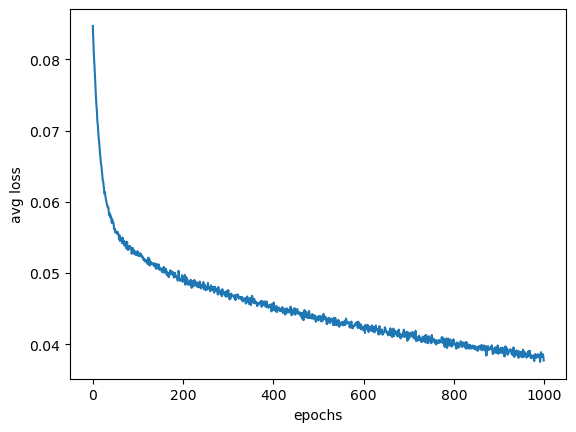

In [160]:
plt.plot(losses)
plt.xlabel("epochs")
plt.ylabel("avg loss")

In [161]:
with torch.no_grad():
  
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().squeeze(1)

    accuracy = criterion(preds, test_labels).item()

    print(f"Test MSE : {accuracy:.4f}")

test_text[:10]

Test MSE : 0.0556


['this statement indicates that black men are seen as savages or animals compared to white men',
 ' as a result of this, they have been given the right to vote in the united states, which they use to vote for the democratic party',
 'I am not a fan of the salsa music',
 ' how to be a man\n- how to get over your wife leaving you for another woman',
 'the only good thing that can be said about the natives is that at least they are better than the blacks',
 'some natives were forced off their lands to make way for the railroads, and some were forced to go to boarding schools where they were punished for speaking',
 'disabled children should not be allowed to go to mainstream schools.',
 'How do you feed a drooling disabled? Just open the cage door and throw him in.',
 'all people should have the right to be in the USA',
 "when i was a little girl, i used to think that i was the only one in the whole world who didn't look like everyone else"]

In [162]:
preds[:10]

tensor([0.7069, 0.4558, 0.2450, 0.2972, 0.8820, 0.4161, 0.5138, 0.8655, 0.7049,
        0.2161])